<a href="https://colab.research.google.com/github/Tasfia48/CS584/blob/main/HW1_Mashiat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




* Team Name: "oishee1995"
* Rank: 8
* Accuracy: 0.85





### Goal: 
My goal for this homework was to predict sentiments for movie reviews. Here, I have built a machine learning model using k-Nearest Neighbors algorithm to predict the sentiments.

In [ ]:
#Load the necessary python libraries
!pip install nltk
import pandas as pd
import matplotlib.pyplot as plt
import re # module for regular experssion operations
import operator
import json

from collections import OrderedDict
from collections import Counter

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from bs4 import BeautifulSoup

from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Load data:
Initially, I load the data from the text files and store them in separate dataframes. The training dataset is in dfTrain and testing dataset is in dfTest. Each dataset has two columns: review and sentiment 



In [ ]:
#Loading training data
docs = []
sentiments = []
with open("1598639150_466036_train_file.txt", "r") as a_file: # path to train file
  for line in a_file:
    split_line = line.split("\t")
    sentiments.append(split_line[0])
    docs.append(split_line[1])
dfTrain = pd.DataFrame()
dfTrain['review'] = docs
dfTrain['sentiment'] = sentiments
dfTrain = dfTrain.iloc[1:]

# Loading Testing data
docTest = []
#sentiments = []
with open("1598639150_4984343_test_file.txt", "r") as a_file: # path to test file
  for line in a_file:
    #split_line = line.split(" ")
    #sentiments.append(split_line[0])
    docTest.append(line)
dfTest = pd.DataFrame()
dfTest['review'] = docTest

### Data Exploration:
To explore the distribution of sentiments accross the training dataset, I visualized the counts of different values for sentiment in the trainning data set. 

In [ ]:
# first five rows of train-data
dfTrain.head(5)

,review,sentiment
1,"""One of the other reviewers has mentioned that...",1
2,"""A wonderful little production. <br /><br />Th...",1
3,"""I thought this was a wonderful way to spend t...",1
4,"""Basically there's a family where a little boy...",-1
5,"""Petter Mattei's """"Love in the Time of Money""""...",1


In [ ]:
# first five rows of test-data
dfTest.head(5)

,review
0,"""This film should have never been made. Honest..."
1,This movie was bad from the start. The only pu...
2,"""God, I never felt so insulted in my whole lif..."
3,"""Not being a fan of the Coen Brothers or Georg..."
4,"""The movie Andaz Apna Apna in my books is the ..."


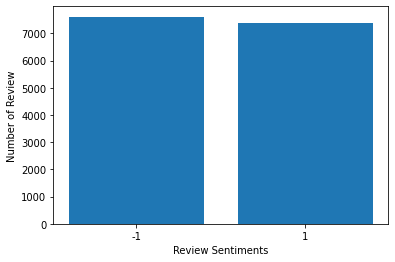

In [ ]:
#ploting counts of different types of sentiment, it seems both values of sentiment(1, -1) is equally distributed
Sentiment_count=dfTrain.groupby('sentiment').count()
plt.bar(Sentiment_count.index.values, Sentiment_count['review'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.show()

### Preprocessing train and test data:
I pre-processed the training and testing dataframes by executing the following steps:
1.   Removing HTML Tags
2.   Removing URL,smileys and Email
3.   Tokenizering review paragraph into words
4.   Removing stopwords from tokenized reviews
5.   Lemmatizing the tokenized filtered reviews





Removing XML and HTML Tags

---
I used the Beautiful Soup which is a Python library for removing the HTML and XML tags from data [1].

In [ ]:
def htmlTagRemove(df):
  htmlRemoved = []
  for ind,row in df.iterrows():
    text_only = BeautifulSoup(row['review']).get_text()
    htmlRemoved.append(text_only)
  return  htmlRemoved

In [ ]:
# Removing XML and HTML Tags
dfTrain['textOnly'] = htmlTagRemove(dfTrain)
dfTest['textOnly'] =htmlTagRemove(dfTest)

Removing URL,smileys and Email  

---


I removed email IDs, URLs, numbers, and emotional symbols from the training and testing reviews using the python module 're' [2].

In [ ]:
def emailURLRemove(df):
  eURRemoved = []      
  for ind,row in df.iterrows():
    noEmail = re.sub(r'([\w\.-]+@[\w\.-]+\.\w+)','',row['textOnly'])
    noUrl = re.sub(r'(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]| \
        [a-z0-9.\-]+[.][a-z]{2,4}/|[a-z0-9.\-]+[.][a-z])(?:[^\s()<>]+|\(([^\s()<>]+| \
        (\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))','', noEmail)
    smileys = """:-) :) :o) :D :-D :( :-( :o(""".split()
    smileyPattern = "|".join(map(re.escape, smileys))    
    letters_only = re.sub("[^a-zA-Z" + smileyPattern + "]", " ", noUrl)  
    eURRemoved.append(letters_only) 
  return  eURRemoved

In [ ]:
#Removing URL,smileys and Email 
dfTrain['emailUrlRemoved']=emailURLRemove(dfTrain)
dfTest['emailUrlRemoved']=emailURLRemove(dfTest)

Tokenizing review paragraphs into words:

---
I have used nltk Word Tokenizer to break the review paragraphs into individual words [3].

In [ ]:
def tokenize(df):
  tokenSent = []
  for ind,row in df.iterrows():
    tokenized_text=word_tokenize(row['emailUrlRemoved'])
    tokenSent.append(tokenized_text)
  return tokenSent;  

In [ ]:
# Tokenizing review paragraphs into words
dfTrain['tokenized']=tokenize(dfTrain)
dfTest['tokenized']=tokenize(dfTest)

Removing stopwords from tokenized reviews:

---


Stopwords considered as noise in the text. Text may contain stop words such as is, am, are, this, a, an, the, etc. I stored the stopwords of english language in a list "stop_words", and filtered out them from the review tokens.Finally coverted the words into lower case.




```
stop_words=set(stopwords.words("english"))
```



In [ ]:
stop_words=set(stopwords.words("english"))
def filtering(df):
  filtered=[]
  for ind,row in df.iterrows():
    tokenized_sent=row['tokenized']
    filtered_sent=[]
    for w in tokenized_sent:
      if w not in stop_words:
          filtered_sent.append(w.lower()) # converting the word into lower case
    filtered.append(filtered_sent)
  return filtered;  

In [ ]:
#Removing stop words
dfTrain['filtered']=filtering(dfTrain)
dfTest['filtered']=filtering(dfTest)

Lemmatizing the tokenized filtered review

---


Another type of noise in text is different types of forms of same word. This noise can be reduced by Lexicon normalization which transforms related forms of a word to a common root word. As lexicon normalizer, I used Lemmatization. Lemmatization reduces words to their base word, which is linguistically correct lemmas. It transforms root word with the use of vocabulary and morphological analysis [4]. Finally I combine the tokens and form review paragraphs again.

In [ ]:
def lemmatizing(df):
  lemmatized=[]
  for ind,row in df.iterrows():
    filtered_sent=row['filtered']
    lemmatized_sent=[]
    for w in filtered_sent:
        lemmatized_sent.append(lem.lemmatize(w))
    str1 = ' '.join(lemmatized_sent)
    lemmatized.append(str1)
  return lemmatized;  

In [ ]:
#Lemmatizing the tokenized filtered review
dfTrain['lemmatized']=lemmatizing(dfTrain)
dfTest['lemmatized']=lemmatizing(dfTest)

In [ ]:
### After pre-processing first five rows of train-data
dfTrain.head(5)

,review,sentiment,textOnly,emailUrlRemoved,tokenized,filtered,lemmatized
1,"""One of the other reviewers has mentioned that...",1,"""One of the other reviewers has mentioned that...",One of the other reviewers has mentioned that...,"[One, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, oz, epis...",one reviewer mentioned watching oz episode hoo...
2,"""A wonderful little production. <br /><br />Th...",1,"""A wonderful little production. The filming te...",A wonderful little production The filming te...,"[A, wonderful, little, production, The, filmin...","[a, wonderful, little, production, the, filmin...",a wonderful little production the filming tech...
3,"""I thought this was a wonderful way to spend t...",1,"""I thought this was a wonderful way to spend t...",I thought this was a wonderful way to spend t...,"[I, thought, this, was, a, wonderful, way, to,...","[i, thought, wonderful, way, spend, time, hot,...",i thought wonderful way spend time hot summer ...
4,"""Basically there's a family where a little boy...",-1,"""Basically there's a family where a little boy...",Basically there s a family where a little boy...,"[Basically, there, s, a, family, where, a, lit...","[basically, family, little, boy, (, jake, ), t...",basically family little boy ( jake ) think zom...
5,"""Petter Mattei's """"Love in the Time of Money""""...",1,"""Petter Mattei's """"Love in the Time of Money""""...",Petter Mattei s Love in the Time of Money ...,"[Petter, Mattei, s, Love, in, the, Time, of, M...","[petter, mattei, love, time, money, visually, ...",petter mattei love time money visually stunnin...


In [ ]:
### After pre-processing first five rows of train-data
dfTest.head(5)

,review,textOnly,emailUrlRemoved,tokenized,filtered,lemmatized
0,"""This film should have never been made. Honest...","""This film should have never been made. Honest...",This film should have never been made Honest...,"[This, film, should, have, never, been, made, ...","[this, film, never, made, honestly, i, must, a...",this film never made honestly i must admit i s...
1,This movie was bad from the start. The only pu...,This movie was bad from the start. The only pu...,This movie was bad from the start The only pu...,"[This, movie, was, bad, from, the, start, The,...","[this, movie, bad, start, the, purpose, movie,...",this movie bad start the purpose movie angela ...
2,"""God, I never felt so insulted in my whole lif...","""God, I never felt so insulted in my whole lif...",God I never felt so insulted in my whole lif...,"[God, I, never, felt, so, insulted, in, my, wh...","[god, i, never, felt, insulted, whole, life, c...",god i never felt insulted whole life crap ther...
3,"""Not being a fan of the Coen Brothers or Georg...","""Not being a fan of the Coen Brothers or Georg...",Not being a fan of the Coen Brothers or Georg...,"[Not, being, a, fan, of, the, Coen, Brothers, ...","[not, fan, coen, brothers, george, clooney, an...",not fan coen brother george clooney anyone see...
4,"""The movie Andaz Apna Apna in my books is the ...","""The movie Andaz Apna Apna in my books is the ...",The movie Andaz Apna Apna in my books is the ...,"[The, movie, Andaz, Apna, Apna, in, my, books,...","[the, movie, andaz, apna, apna, books, top, in...",the movie andaz apna apna book top intelligent...


### Feature Engineering: 
For feature engineering, I have used TF-IDF scores. TF-IDF stands for Term Frequency — Inverse Document Frequency. This metric considers the number of appearance of a word in a document vs the number of appearance same word appears other documents in the dataset. And for every word, the TF-IDF value increases with every appearance of the word in a document, but is gradually decreased with every appearance in other documents.
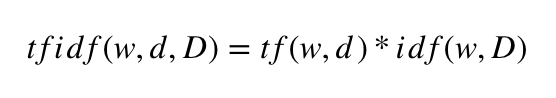

where, 
*   f(w, d) = term-frequecy of word w in document d 
*   tf(w,d) = log(1+f(w,d))
*   f(w,D) = term-frequency of word w in whole dataset D
*   idf(w,D) = log(N/f(w,D)), for N number of documents


      


       


I used TF-IDF Sklearn Python to calculate the tf-idf score. There are two different ways of implementing TF-IDF using Scikit-Learn. One is using the TfidfVectorizer class and the other one is by using the TfidfTransformer class.I TfidfVectorizer class for calualting TF-IDF for each word w. For the purpose of experimenting, I applied two approach of this class to validate my K-nearest neighbor classifier.

1.   TfidfVectorizer()- Usual class which takes the counts for each word to generate score.
2.   TfidfVectorizer(binary=True)- If True, all non-zero term counts are set to 1. This does not mean outputs will have only 0/1 values, only that the tf term in tf-idf is binary. It only check whether the word was in the document or not. As this is a binary classification problem, the reviews are either positive or negative, I thought it will be a good idea to try it out. In case of multi-class problem this method may not result in better accuracy.



I compared the results for both of them.

In [ ]:
# Calculating tf-idf scores
tf=TfidfVectorizer() # TfidfVectorizer with non-binary tf term
tf_fit = tf.fit(dfTrain['lemmatized']) #Learning vocabulary and idf from training set.
text_tf= tf_fit.transform(dfTrain['lemmatized']) #Transforming documents to document-term matrix.

In [ ]:
# Calculating tf-idf scores
tfBinary=TfidfVectorizer(binary=True) #TfidfVectorizer with binary tf term
tfBinary_fit = tfBinary.fit(dfTrain['lemmatized']) #Learning vocabulary and idf from training set.
text_tfBinary= tfBinary_fit.transform(dfTrain['lemmatized']) #Transforming documents to document-term matrix.

### K Nearnest Neighbor Algorithm

In my K Nearnest Neighbor Classifier, I took the preprocessed reviews of training, testing set, sentiments for training set, and the value of K as argument. In next step, I calculated the Tf-idf scores using Tf-idf model for both of the reviews of training and testing data set. Later, I calculated the cosine similarity between them and store the values in a dictionary. where the key is each review of the test set and the values are the similarities with each review of the train set. Then I took top K training set with maximum similarity and performed majority voting on the sentiments of K number of nearest reviews. Stored the sentiment prediction for each test-set entity in a list predicted and returned it. The vocabulary size for my dataset was around 55k.

In [ ]:
def KNN(X_test,X_train,y_train,k):
  tfBinary_fit =tfBinary.fit(X_train)
  Xtrain =tfBinary_fit.transform(X_train) #Transforming documents to document-term matrix
  Xtest =tfBinary_fit.transform(X_test) #Transforming documents to document-term matrix
  sim_sparse = cosine_similarity( Xtest, Xtrain, dense_output=False) # calculating cosine similarity for each entry of test set with all entries of training set
  sim = sim_sparse.toarray()
  y_train = y_train.values
  predicted=[]
  for j in range(0,len(sim)):
    dicta={}
    for i in range(0,len(sim[j])):
      dicta[i] = sim[j][i]
      # print(i,j)
    d_descending = OrderedDict(sorted(dicta.items(), 
                                      key=lambda t: t[1],reverse=True)) #used orderedDict to sort the dictionary based on similarity
    temp=[]
    for u in list(d_descending)[0:k]:
      temp.append(y_train[u])
    # print(temp)
    m = Counter(temp).most_common()[0][0] # used counter to implement majority voting thus getting the most common value
    predicted.append(m)
  return predicted;  

### Training and Testing Set split
To validate my model, I split the training data set into training set and validation set or test set. The test set is the 20% of the original training dataset and the train set is the rest 80%.  

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    dfTrain['lemmatized'], dfTrain['sentiment'], test_size=0.2, random_state=1)

In [ ]:
predicted  = KNN(X_test,X_train,y_train,56)
print("Prediction accuracy", metrics.accuracy_score(y_test, predicted))

Prediction accuracy 0.8643333333333333


In [ ]:
#Commenting out this portion of determining k value as it takes a lot of time to calculate accuracy for 96 values of K. I have attached the .json file storing the accuracy values
accuracy={}
for i in range(3,100):
  predicted  = KNN(X_test,X_train,y_train,i)
  a = metrics.accuracy_score(y_test, predicted)
  accuracy[i]=a
  
with open('my_dict.json', 'w') as f:
    json.dump(accuracy, f)

### Determining the value of K

For determinig the appropriate K value which will maximize the accuracy, I calculated the prediction for K values range(3 to 99) and calculated the accuracy using sklearn.accuracy_metrics. I excuted the algorithm for both the usual Tfidf and binary Tfidf vectorizer and ploted the accuracy observed for each K. Stored in json files. The values can be again gained from the json files.

In [ ]:
#Loading dictionaries with accuracy with K values. Keys: K value, Value: Accuracy
with open('my_dict1.json') as f:
    temp = json.load(f)
accuracy = {}
for key in temp.keys():
    accuracy[int(key)] = temp[key] # converting the datatype of dictinary to int for ploting purpose   

#accuracy = {int(k):int(v) for k,v in accuracy.items()}    
with open('my_dict.json') as f:
    temp = json.load(f)
accuracyBinary = {}
for key in temp.keys():
    accuracyBinary[int(key)] = temp[key]    


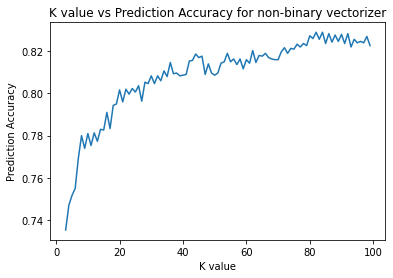

In [ ]:
lists = sorted(accuracy.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.xlabel("K value")
plt.ylabel("Prediction Accuracy")
plt.title("K value vs Prediction Accuracy for non-binary vectorizer")
plt.show()

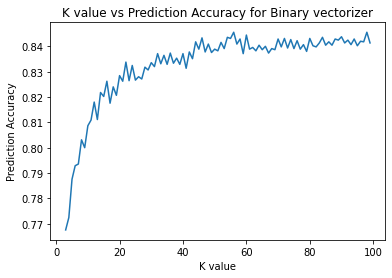

In [ ]:
lists = sorted(accuracyBinary.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.xlabel("K value")
plt.ylabel("Prediction Accuracy")
plt.title("K value vs Prediction Accuracy for Binary vectorizer")
plt.show()

From the above plots, it can been seen that the classifier provides better accuracy for the binary tf-idf vectorizer.

In [ ]:
max_key = max(accuracyBinary, key=accuracyBinary. get) 
print( "K=", max_key,", Accuracy=", accuracyBinary[max_key])

K= 56 , Accuracy= 0.8455555555555555


For K = 56, the prediction accuracy was maximum. 
Accuracy = 0.845555555

### K fold cross validation

For testing the KNN classifier, I also executed the 3fold and 5fold cross validation on the originial data set and measured the accuracy scores for K= 56. 

In [ ]:
from sklearn.model_selection import KFold
kf5 = KFold(n_splits=5, shuffle=False)
kf3 = KFold(n_splits=3, shuffle=False)
i = 1
# 5-fold validation for K =56
for train_index, test_index in kf5.split(dfTrain):
    X_train = dfTrain.iloc[train_index].loc[:, 'lemmatized']
    X_test = dfTrain.iloc[test_index]['lemmatized']
    y_train = dfTrain.iloc[train_index].loc[:,'sentiment']
    y_test = dfTrain.iloc[test_index]['sentiment']
    predicted = KNN(X_test,X_train,y_train,56)
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, KNN(X_test,X_train,y_train,56))}")
    i += 1

Accuracy for the fold no. 1 on the test set: 0.8583333333333333
Accuracy for the fold no. 2 on the test set: 0.8503333333333334
Accuracy for the fold no. 3 on the test set: 0.8423333333333334
Accuracy for the fold no. 4 on the test set: 0.8416666666666667
Accuracy for the fold no. 5 on the test set: 0.8499499833277759


In [ ]:
# 3-fold validation for K =56
i = 1
for train_index, test_index in kf3.split(dfTrain):
    X_train = dfTrain.iloc[train_index].loc[:, 'lemmatized']
    X_test = dfTrain.iloc[test_index]['lemmatized']
    y_train = dfTrain.iloc[train_index].loc[:,'sentiment']
    y_test = dfTrain.iloc[test_index]['sentiment']
    predicted = KNN(X_test,X_train,y_train,56)
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, KNN(X_test,X_train,y_train,56))}")
    i += 1

Accuracy for the fold no. 1 on the test set: 0.854
Accuracy for the fold no. 2 on the test set: 0.838
Accuracy for the fold no. 3 on the test set: 0.8473694738947789


### Predicting sentiment for the testing dataset

In [ ]:
X_test = dfTest['lemmatized']
X_train = dfTrain['lemmatized']
y_train = dfTrain['sentiment']
predicted = KNN(X_test,X_train,y_train,56)

In [ ]:
with open('format.txt', 'w') as filehandle:
    for listitem in predicted:
        filehandle.write('%s\n' % listitem)

### References:


1.  https://www.crummy.com/software/BeautifulSoup/bs4/doc/
2.  https://github.com/sowmyagowri/IMDB-Movie-Review-Classification/blob/master/Classifier.ipynb?fbclid=IwAR16EvL2novWBnU6q2TGopCHscHz5pwcuQEScsEfh6HhEwOqz1awsZCeo4o
3. https://pythonspot.com/tokenizing-words-and-sentences-with-nltk/
4. https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
5. https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275

